# **Projet 5. Optimisez la gestion des données d'une boutique avec R ou Python**

## **Table des matières** 

* [Mission 1. Rapprochement de deux exports](#chapter1)
* [Mission 2. Le chiffre d’affaires par produit, le total du chiffre d’affaires réalisé en ligne](#chapter2)
* [Mission 3. Erreurs de saisie dans la variable "price"](#chapter3)
    * [1) Boxplot](#section_3_1)
    * [2) Z-score](#section_3_2)
    * [3) Inter Quartile Range (IQR)](#section_3_3)
    * [4) Vérifications](#section_3_4)
    * [5) Exemple de classification des vins](#section_3_5)    
    

## **Mission 1. Rapprochement de deux exports** <a class="anchor" id="chapter1"></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker #y scale
from IPython.display import display #affichage des tableaux
from collections import Counter

In [2]:
erp=pd.read_csv('erp.csv', header=0, encoding='latin1')
web=pd.read_csv('web.csv', parse_dates=[9, 10, 19, 20], header=0, encoding='latin1')

In [3]:
web=web.rename(columns={'sku': 'id_web'})

In [4]:
web=web[~(web.id_web.isna() & web.guid.isna())] # on suprime les lignes ou il n'y a ni id_web, ni lien avec id_web

In [5]:
web.sort_values(by='id_web').head(10)

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
1399,10014,0,0,0,0.0,0.0,NaN,NaN,2.0,2019-04-04 15:45:23,...,darnleys-london-dry-gin-original,2020-08-26 15:55:02,2020-08-26 13:55:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
628,10014,0,0,0,0.0,0.0,taxable,NaN,2.0,2019-04-04 15:45:23,...,darnleys-london-dry-gin-original,2020-08-26 15:55:02,2020-08-26 13:55:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
255,10459,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-04-13 15:58:19,...,alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1046,10459,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-04-13 15:58:19,...,alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1106,10775,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-04-17 21:28:52,...,albert-mann-pinot-gris-vendanges-tardives-alte...,2018-12-22 10:30:02,2018-12-22 09:30:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
321,10775,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-04-17 21:28:52,...,albert-mann-pinot-gris-vendanges-tardives-alte...,2018-12-22 10:30:02,2018-12-22 09:30:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1072,10814,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-04-17 10:12:40,...,thierry-germain-saumur-champigny-outre-terre-2013,2020-08-05 14:35:02,2020-08-05 12:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
281,10814,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-04-17 10:12:40,...,thierry-germain-saumur-champigny-outre-terre-2013,2020-08-05 14:35:02,2020-08-05 12:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
257,11049,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-04-13 16:07:49,...,alphonse-mellot-sancerre-rouge-en-grands-champ...,2020-01-31 09:30:02,2020-01-31 08:30:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1048,11049,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-04-13 16:07:49,...,alphonse-mellot-sancerre-rouge-en-grands-champ...,2020-01-31 09:30:02,2020-01-31 08:30:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


Il y a des doublons de id_web, post_name, dates. La première ligne ne contient qu'un liens vers une image. La deuxième contient toute l'information sur le produit à l'exception du liens vers l'image. Il sera interessant d'unir ces deux lignes.

In [6]:
# est'ce que c'est possible d'utiliser web_id comme un index unique ? ces trois valeurs doivent être égales 
# on verifie qu'il n'y a pas de doublons de id_web et qu'il n'y a pas de valeurs manquantes de id_web
print(web[~web.id_web.isna()]['post_mime_type'].count())
print(web['post_mime_type'].count())
print(len(web[web.post_mime_type=='image/jpeg']['id_web'].unique()))

714
714
714


In [7]:
# on crée un tableaux avec seulement les lignes qui contiennent des attachements, avec 2 colonnes: id_web (comme index qui nous permettra de reunir les tableaux après) et guid
image=web[web.post_mime_type=='image/jpeg'][['id_web', 'guid']]
image=image.rename(columns={'guid': 'image'})

In [8]:
# maintenant on peut supprimer toutes les lignes avec des attachements du tableau initial
web=web[~(web.post_mime_type=='image/jpeg')]

In [9]:
# on connecte les produits du nouveau tableau (sans doublons de id_web) et une colonne 'image' via id_web
web=web.merge(image, on='id_web', how='left')

In [10]:
# on extrait product_id de la colonne 'guid' et on crée une nouvelle colonne avec cette variable
detected_id=[]
for link in web['guid']:
    id=int(link.replace('https://www.bottle-neck.fr/?post_type=product&#038;p=', ''))
    detected_id.append(id)
web['product_id']=detected_id

In [11]:
# on fusionne les tableaux web et erp (web est plus important pour nous, car il y a des nombres de ventes -> 'left jointure')
erp_web=pd.merge(web, erp, how='left', on='product_id')


In [14]:
# on verifie s'il y a des colonnes inutiles
erp_web.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,tax_class,post_author,post_content,post_password,post_content_filtered,post_parent,menu_order,comment_count,product_id,onsale_web,price,stock_quantity
count,716.0,716.0,716.0,716.0,716.000000,0.0,716.000000,0.0,0.0,0.0,716.0,716.0,716.0,716.000000,716.0,716.000000,716.000000
mean,0.0,0.0,0.0,0.0,4.001397,NaN,1.998603,NaN,NaN,NaN,0.0,0.0,0.0,5032.668994,1.0,32.581145,28.666201
std,0.0,0.0,0.0,0.0,8.508901,NaN,0.037372,NaN,NaN,NaN,0.0,0.0,0.0,789.407324,0.0,27.842942,47.969443
min,0.0,0.0,0.0,0.0,0.000000,NaN,1.000000,NaN,NaN,NaN,0.0,0.0,0.0,3847.000000,1.0,5.200000,0.000000
25%,0.0,0.0,0.0,0.0,0.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0,4280.750000,1.0,14.100000,2.000000
50%,0.0,0.0,0.0,0.0,1.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0,4798.000000,1.0,23.650000,12.000000
75%,0.0,0.0,0.0,0.0,4.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0,5709.500000,1.0,42.300000,35.000000
max,0.0,0.0,0.0,0.0,96.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0,7338.000000,1.0,225.000000,578.000000


In [15]:
# on supprime les colonnes inutiles
erp_web.drop(columns=['virtual', 'downloadable', 'rating_count', 'average_rating', 'tax_class', 'post_content', 'post_password', 'post_content_filtered', 'post_parent', 'menu_order', 'post_mime_type', 'comment_count', 'onsale_web'], inplace=True)

In [16]:
# on enregistre le tableau final
erp_web.to_csv(r'/home/remi/erp_web.csv', index = False, header=True)

## **Mission 2. Le chiffre d’affaires par produit, le total du chiffre d’affaires réalisé en ligne** <a class="anchor" id="chapter2"></a>

In [18]:
# on ouvre le fichier nettoyé et préparé
erp_web=pd.read_csv('erp_web.csv', parse_dates=[9, 10, 19, 20], header=0, encoding='latin1')


In [19]:
# on verifie que product_id pourra être un index, ces deux valeurs doivent être égales :
print(len(erp_web['product_id'].unique()))
print(len(erp_web))

716
716


In [20]:
# on fixe produi_id comme l'index
erp_web.set_index('product_id', inplace=True)

In [21]:
erp_web['total_sales'] = pd.to_numeric(erp_web['total_sales'], downcast="float")
erp_web['price'] = pd.to_numeric(erp_web['price'], downcast="float")
ca_total=sum(erp_web['total_sales']*erp_web['price'])
print("Le total du chiffre d’affaires réalisé en ligne est %.2f euros" % ca_total)

Le total du chiffre d’affaires réalisé en ligne est 70568.60 euros


In [22]:
# on crée une colonne avec CA par produit
erp_web['chiffre d\'affaires']=erp_web["total_sales"]*erp_web["price"]

In [99]:
# on affiche des CA par produit dans l'ordre décroissant, où les CA ne sont pas égals à zéro
pd.set_option('display.max_rows', None)

display(erp_web[erp_web['chiffre d\'affaires']!=0][['total_sales', 'price', 'chiffre d\'affaires']].sort_values(by='chiffre d\'affaires', ascending=False).style.format({'total_sales': "{:.0f}", 'price': "{:.2f}", 'chiffre d\'affaires': "{:.2f}"}))

,total_sales,price,chiffre d'affaires
product_id,,,
4334,96,49.00,4704.00
4144,87,49.00,4263.00
4402,13,176.00,2288.00
4142,30,53.00,1590.00
4141,40,39.00,1560.00
4355,11,126.50,1391.50
4352,5,225.00,1125.00
4153,36,29.00,1044.00
6206,41,25.20,1033.20


## **Mission 3. Erreurs de saisie dans la variable "price"**<a class="anchor" id="chapter3"></a>

### **1) Boxplot**<a class="anchor" id="section_3_1"></a>

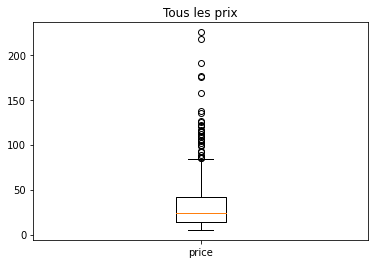

In [58]:
# on cherche outliers avec la boîte à moustaches
plt.boxplot(erp_web['price'])
plt.xticks([1], ['price'])
plt.title('Tous les prix')
plt.show()

Ici les outliers potentiels sont les produit où le prix est supérieur  ou égal à 74.5 euros

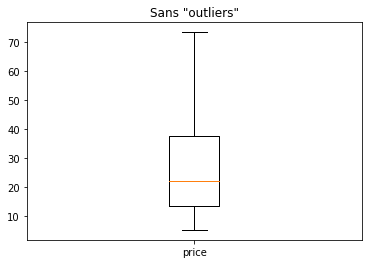

In [62]:
plt.boxplot(erp_web[erp_web['price']<74.5]['price'])
plt.xticks([1], ['price'])
plt.title('Sans "outliers"')
plt.show()

In [91]:
outliers_bp=[]
erp_web[erp_web.price>=74.5]['price'].map(lambda x: outliers_bp.append(round(x,2)))
print('Nombre d\'outliers potentiels détectés:', len(outliers_bp))
print('Outliers potentiels détectés:{}'.format(outliers_bp))

Nombre d'outliers potentiels détectés: 50
Outliers potentiels détectés:[80.0, 77.8, 100.0, 88.4, 77.4, 79.8, 83.0, 79.5, 225.0, 79.5, 126.5, 77.0, 85.6, 176.0, 108.5, 157.0, 104.0, 109.6, 76.8, 78.0, 102.3, 137.0, 78.0, 78.0, 78.0, 217.5, 105.0, 105.0, 112.0, 86.8, 84.7, 92.0, 83.7, 124.8, 175.0, 191.3, 93.0, 122.0, 114.0, 74.5, 74.8, 135.0, 105.6, 116.4, 115.0, 121.0, 99.0, 115.0, 121.0, 78.0]


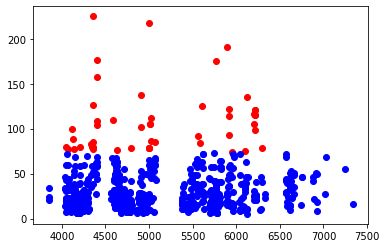

In [129]:
plt.scatter(erp_web[erp_web.price>=74.5]['price'].index, erp_web[erp_web.price>=74.5]['price'].values, c='red')
plt.scatter(erp_web[erp_web.price<74.5]['price'].index, erp_web[erp_web.price<74.5]['price'].values, c='blue')
plt.show()

### **2) Z-score**<a class="anchor" id="section_3_2"></a>

In [94]:
from scipy import stats
outliers_z=[]
z_score=pd.DataFrame(erp_web['price'].copy())
z_score['z_scr']=stats.zscore(z_score['price'])
z_score[z_score['z_scr'].abs()>2]['price'].map(lambda x: outliers_z.append(round(x,2)))
print('Nombre d\'outliers potentiels détectés:', len(outliers_z))
print('Outliers potentiels détectés:{}'.format(outliers_z))

Nombre d'outliers potentiels détectés: 30
Outliers potentiels détectés:[100.0, 88.4, 225.0, 126.5, 176.0, 108.5, 157.0, 104.0, 109.6, 102.3, 137.0, 217.5, 105.0, 105.0, 112.0, 92.0, 124.8, 175.0, 191.3, 93.0, 122.0, 114.0, 135.0, 105.6, 116.4, 115.0, 121.0, 99.0, 115.0, 121.0]


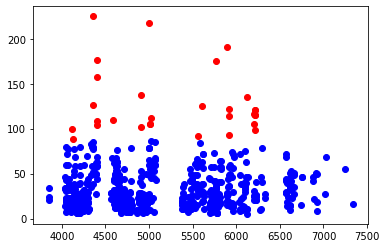

In [128]:
plt.scatter(z_score[z_score['z_scr'].abs()>2]['price'].index, z_score[z_score['z_scr'].abs()>2]['price'].values, c='red')
plt.scatter(z_score[z_score['z_scr'].abs()<=2]['price'].index, z_score[z_score['z_scr'].abs()<=2]['price'].values, c='blue')
plt.show()

### **3) Inter Quartile Range (IQR)**<a class="anchor" id="section_3_3"></a>

In [132]:
outliers_iqr=[]
Q1=erp_web.price.quantile(.25)
Q3=erp_web.price.quantile(.75)
IQR=Q3-Q1
Min_value=Q1-1.5*IQR
Max_value=Q3+1.5*IQR
erp_web.price[(erp_web.price <= Min_value) | (erp_web.price >= Max_value)].map(lambda x: outliers_iqr.append(round(x,2)))
print('Nombre d\'outliers potentiels détectés:', len(outliers_iqr))
print('Outliers potentiels détectés:{}'.format(outliers_iqr))



Nombre d'outliers potentiels détectés: 33
Outliers potentiels détectés:[100.0, 88.4, 225.0, 126.5, 85.6, 176.0, 108.5, 157.0, 104.0, 109.6, 102.3, 137.0, 217.5, 105.0, 105.0, 112.0, 86.8, 84.7, 92.0, 124.8, 175.0, 191.3, 93.0, 122.0, 114.0, 135.0, 105.6, 116.4, 115.0, 121.0, 99.0, 115.0, 121.0]


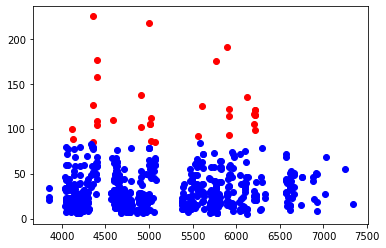

In [136]:
plt.scatter(erp_web[(erp_web.price <= Min_value) | (erp_web.price >= Max_value)]['price'].index, erp_web[(erp_web.price <= Min_value) | (erp_web.price >= Max_value)]['price'].values, c='red')
plt.scatter(erp_web[(erp_web.price > Min_value) & (erp_web.price < Max_value)]['price'].index, erp_web[(erp_web.price > Min_value) & (erp_web.price < Max_value)]['price'].values, c='blue')
plt.show()

### **4) Vérifications**<a class="anchor" id="section_3_4"></a>

In [102]:
erp_web[erp_web.price>=74.5][['post_title', 'price']].sort_values(by='price', ascending=False).head(10).style.format({'price': "{:.2f}"})

,post_title,price
product_id,,
4352,Champagne Egly-Ouriet Grand Cru MillÂsimÂ 2008,225.00
5001,David Duband Charmes-Chambertin Grand Cru 2014,217.50
5892,Coteaux Champenois Egly-Ouriet Ambonnay Rouge 2016,191.30
4402,Cognac Frapin VIP XO,176.00
5767,Camille Giroud Clos de Vougeot 2016,175.00
4406,Cognac Frapin ChÂteau de Fontpinot 1989 20 Ans d'Age,157.00
4904,Domaine Des Croix Corton Charlemagne Grand Cru 2016,137.00
6126,Champagne Gosset CÂlÂbris Vintage 2007,135.00
4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.50


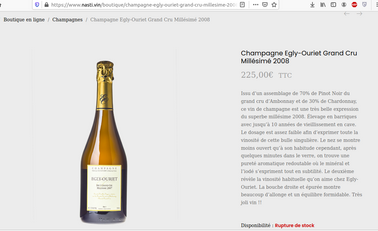

In [107]:
from PIL import Image
vin1 = Image.open("vin1.png");
vin1

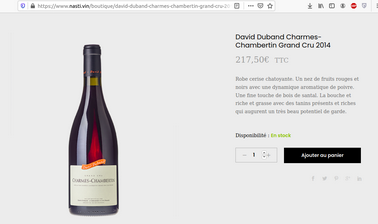

In [108]:
vin2 = Image.open("vin2.png");
vin2

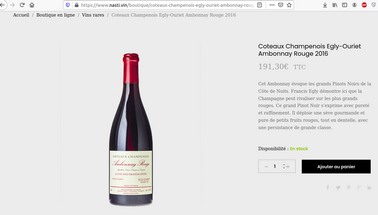

In [109]:
vin3 = Image.open("vin3.png");
vin3

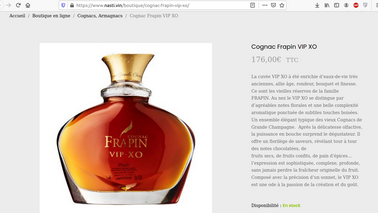

In [110]:
vin4 = Image.open("vin4.png");
vin4

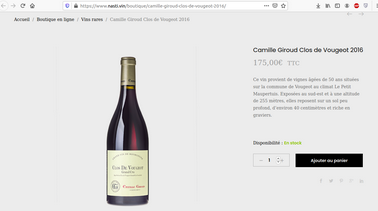

In [111]:
vin5 = Image.open("vin5.png");
vin5

On voit bien que les vins les plus chers sont les vins de luxe. Le prix de ces vins est juste. D'où on peut conclure qu'il n'y a pas d'outliers dans notre base de données.
En général, les prix du vin défient la loi normale. Plus le vin est rare plus il est cher, et vice versa. Par exemple, Champagne Egly-Ouriet Grand Cru Millésimé, produit en 2008, est rare grâce à son année de production.

### **5) Exemple de classification des vins**<a class="anchor" id="section_3_5"></a>

Pour construir des bons boxplots qui n'afficheront des outliers, on va essayer de segmenter nos bouteilles de vins par rapport au prix. Pour cela je vais utiliser la classification qui est utilisé dans le monde anglophone.

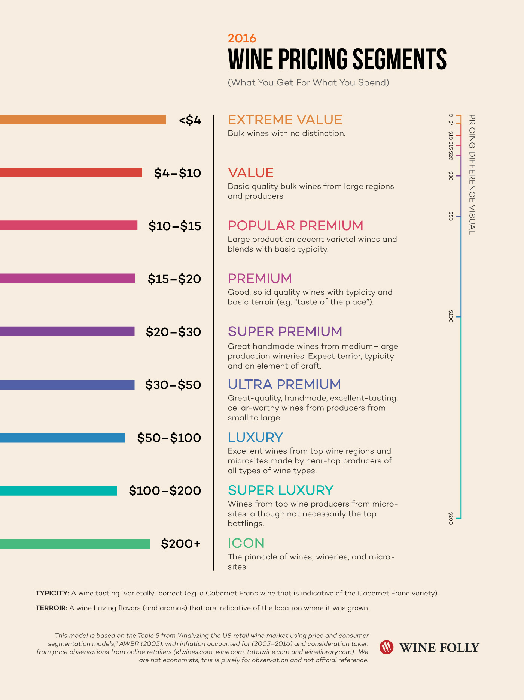

In [123]:
wine_pricing_segments = Image.open("wine-pricing-segments.jpg");
height_percent = (700 / float(wine_pricing_segments.size[1]))
width_size = int((float(wine_pricing_segments.size[0]) * float(height_percent)))
wine_pricing_segments = wine_pricing_segments.resize((width_size, 700), Image.NEAREST)
wine_pricing_segments

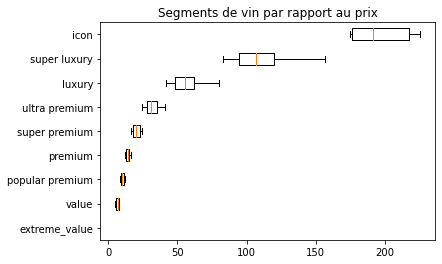

In [115]:
# on convert $ en € et conctruit un boxplot par segment
fig, ax = plt.subplots()
ax.boxplot([erp_web[erp_web.price<3.3]['price'], 
            erp_web[(erp_web.price>=3.3) & (erp_web.price<8.3)]['price'],
            erp_web[(erp_web.price>=8.3) & (erp_web.price<12.4)]['price'],
            erp_web[(erp_web.price>=12.4) & (erp_web.price<16.6)]['price'],
            erp_web[(erp_web.price>=16.6) & (erp_web.price<24.8)]['price'],
            erp_web[(erp_web.price>=24.8) & (erp_web.price<41.4)]['price'],
            erp_web[(erp_web.price>=41.4) & (erp_web.price<82.8)]['price'], 
            erp_web[(erp_web.price>=82.8) & (erp_web.price<165.5)]['price'], 
            erp_web[erp_web.price>=165.5]['price']], vert=False)
ax.set_yticklabels(['extreme_value', 'value', 'popular premium', 'premium', 'super premium', 'ultra premium', 'luxury', 'super luxury', 'icon'])
plt.title('Segments de vin par rapport au prix')
plt.show()


Si on construit des boxplots en séparant des vins selon leur prix, on voit bien, que les marquers des outliers disparessent.